In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import hstack, kron, eye, csc_matrix, block_diag

# Pymatching tutorial

Lets start with the lattice

In [2]:
def repetition_code(n):
    """
    Parity check matrix of a repetition code with length n.
    """
    row_ind, col_ind = zip(*((i, j) for i in range(n) for j in (i, (i+1)%n)))
    data = np.ones(2*n, dtype=np.uint8)
    return csc_matrix((data, (row_ind, col_ind))) # M[row[i], col[i]] = data[i]

def toric_code_x_stabilisers(L):
    """
    Sparse check matrix for the X stabilisers of a toric code with
    lattice size L, constructed as the hypergraph product of
    two repetition codes.
    """
    Hr = repetition_code(L)
    H = hstack(
            [kron(Hr, eye(Hr.shape[1])), kron(eye(Hr.shape[0]), Hr.T)],
            dtype=np.uint8
        )
    H.data = H.data % 2
    H.eliminate_zeros()
    return csc_matrix(H)

X staibilzers is given by $(H_r \otimes 1 ~ | ~ 1 \otimes H_r^T ) $ which is a L^2 x 2L^2 matrix 

In [3]:
def toric_code_x_logicals(L):
    """
    Sparse binary matrix with each row corresponding to an X logical operator
    of a toric code with lattice size L. Constructed from the
    homology groups of the repetition codes using the Kunneth
    theorem.
    """
    H1 = csc_matrix(([1], ([0],[0])), shape=(1,L), dtype=np.uint8)
    H0 = csc_matrix(np.ones((1, L), dtype=np.uint8))
    x_logicals = block_diag([kron(H1, H0), kron(H0, H1)])
    x_logicals.data = x_logicals.data % 2
    x_logicals.eliminate_zeros()
    return csc_matrix(x_logicals)

# Lets simulate some stuff 

In [4]:
N = 8
p = .1

H = toric_code_x_stabilisers(N)
LH = toric_code_x_logicals(N)

In [5]:
from pymatching import Matching
matching=Matching(H,weights=np.log((1-p)/p))

In [6]:
noise = np.random.binomial(1,p,H.shape[1])

syndrome = H @ noise%2
predicted_noise = matching.decode(syndrome)

logical_flip_pred = LH @ predicted_noise % 2
logical_flip_result = LH @ noise % 2

print('Prediction was ', (logical_flip_pred == logical_flip_result).all())

Prediction was  True


In [7]:
import networkx as nx
graph_mat = matching.to_networkx()
#nx.draw(graph_mat, with_labels = True)
graph_mat.edges[0,56]


{'fault_ids': {0}, 'weight': 2.1972245773362196, 'error_probability': -1.0}

Lets do some bonafide simulation:

In [8]:
import time

In [9]:
N_shots = 50000
N_corr = 0
for _ in range(N_shots):
    noise = np.random.binomial(1,p,H.shape[1])

    syndrome = H @ noise%2
    predicted_noise = matching.decode(syndrome)

    logical_flip_pred = LH @ predicted_noise % 2
    logical_flip_result = LH @ noise % 2

    if (logical_flip_pred == logical_flip_result).all():
        N_corr +=1

print('Failute rate was', 1- N_corr/N_shots)

Failute rate was 0.26280000000000003


Now lets find phase tansition:

In [10]:
N_shots = 10000

L = np.array([4,8,12])
prob = np.array([.01 * i for i in range(16)])

Error_Mat = np.zeros((L.shape[0], prob.shape[0]))

for l in L:
    H = toric_code_x_stabilisers(l)
    LH = toric_code_x_logicals(l)

    matching = Matching(H, weights=np.log((1-p)/p), faults_matrix=LH)

    for p in prob:
        N_corr = 0

        for _ in range(N_shots):
            noise = np.random.binomial(1,2*p,H.shape[1])

            syndrome = H @ noise%2
            logical_flip_pred = matching.decode(syndrome)

            logical_flip_result = LH @ noise % 2

            if (logical_flip_pred == logical_flip_result).all():
                N_corr +=1

        Error_Mat[np.argwhere(L==l),np.argwhere(prob == p)] = 1- N_corr/N_shots 
            
        



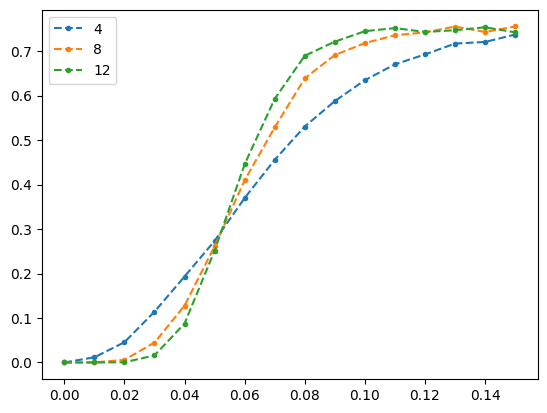

In [11]:
plt.figure()
for i in range(L.shape[0]): 
    plt.plot(prob, Error_Mat[i], '.--', label = L[i])

plt.legend()
plt.show()

# Measurement errors

https://pymatching.readthedocs.io/en/stable/toric-code-example.html#Noisy-syndromes

In [45]:
N = 8
p = .03
T=4

H = toric_code_x_stabilisers(N)
LH = toric_code_x_logicals(N)


matching_meas = Matching(H, repetitions = T)

In [46]:
num_stabilisers, num_qubits = H.shape
noise_new = (np.random.rand(num_qubits, T) < p).astype(np.uint8)
noise_cumulative = (np.cumsum(noise_new, 1) % 2).astype(np.uint8)
noise_total = noise_cumulative[:,-1]

In [47]:
syndrome = H@noise_cumulative % 2
syndrome_error = (np.random.rand(num_stabilisers, T) < p).astype(np.uint8)
syndrome_error[:,-1] = 0 # Perfect measurements in last round to ensure even parity
noisy_syndrome = (syndrome + syndrome_error) % 2
noisy_syndrome[:,1:] = (noisy_syndrome[:,1:] - noisy_syndrome[:,0:-1]) % 2

matching = Matching(H, weights=np.log((1-p)/p),
                repetitions=T, timelike_weights=np.log((1-p)/p), faults_matrix=None)

matching.decode(noisy_syndrome)

array([0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1], dtype=uint8)

In [56]:
noisy_syndrome.shape

(64, 4)

In [49]:
def num_decoding_failures_noisy_syndromes(H, logicals, p, q, num_shots, repetitions):
    matching = Matching(H, weights=np.log((1-p)/p),
                repetitions=repetitions, timelike_weights=np.log((1-q)/q), faults_matrix=None)
    num_stabilisers, num_qubits = H.shape
    num_errors = 0
    for i in range(num_shots):
        noise_new = (np.random.rand(num_qubits, repetitions) < p).astype(np.uint8)
        noise_cumulative = (np.cumsum(noise_new, 1) % 2).astype(np.uint8)
        noise_total = noise_cumulative[:,-1]
        syndrome = H@noise_cumulative % 2
        syndrome_error = (np.random.rand(num_stabilisers, repetitions) < q).astype(np.uint8)
        syndrome_error[:,-1] = 0 # Perfect measurements in last round to ensure even parity
        noisy_syndrome = (syndrome + syndrome_error) % 2
        # Convert to difference syndrome
        noisy_syndrome[:,1:] = (noisy_syndrome[:,1:] - noisy_syndrome[:,0:-1]) % 2
        predicted_logicals_flipped = matching.decode(noisy_syndrome)
        actual_logicals_flipped = noise_total@logicals.T % 2
        if not np.array_equal(predicted_logicals_flipped, actual_logicals_flipped):
            num_errors += 1
    #return num_errors
    return predicted_logicals_flipped, noisy_syndrome


In [50]:
A = num_decoding_failures_noisy_syndromes(H, LH, p, .02, 100, 5)


In [51]:
A[1].shape

(64, 5)

In [52]:
H.toarray().shape

(64, 128)